# Numerical Classification - Iris Dataset - Interpretability 

In [1]:
print("Bismillahir Rahmanir Rahim")

Bismillahir Rahmanir Rahim


## Imports and Paths

In [131]:
from IPython.display import display, HTML

from lime.lime_tabular import LimeTabularExplainer

from pprint import pprint

from scipy.spatial.distance import pdist, squareform

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics.pairwise import cosine_similarity

%matplotlib inline

import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pathlib
import sklearn
import seaborn as sns

import eli5
import lime
import shap
shap.initjs()

## Loading and preprocessing

In [219]:
# Set the seed experimentations and interpretations.
np.random.seed(111)

from sklearn.datasets import load_iris
iris = load_iris()
train, test, labels_train, labels_test = train_test_split(iris.data, iris.target, train_size=0.80)

In [220]:
print(train[0:1])
print(iris.feature_names)
print(iris.target_names)

print(labels_train[0:1])

[[4.6 3.6 1.  0.2]]
['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
['setosa' 'versicolor' 'virginica']
[0]


In [831]:
print(np.unique(iris.target))

[0 1 2]


In [823]:
''' Using Seaborn iris dataset with preprocessing

Not working. Instead use sklearn iris dataset.
'''

# df_iris = sns.load_dataset("iris")

# from sklearn import preprocessing
# le = preprocessing.LabelEncoder()
# le.fit(df_iris['species'])
# df_iris['species_encoded'] = le.transform(df_iris['species'])

# df_iris_species = df_iris['species']
# df_iris_pre = df_iris.drop(columns=['species'])
# display(df_iris_pre.head())


# df_train, df_test = train_test_split(df_iris, train_size=0.80)
# df_labels_train = df_train['species_encoded']
# df_labels_test = df_test['species_encoded']

# df_train = df_train.iloc[:, 0:4]
# df_test = df_test.iloc[:, 0:4]

# iris_feature_names = df_iris.iloc[:, 0:4].columns
# iris_target_names = df_iris['species'].unique()
# print(iris_feature_names)
# print(iris_target_names)

' Using Seaborn iris dataset with preprocessing\n\nNot working. Instead use sklearn iris dataset.\n'

## Model Fitting and Evaluation

### 1. Black Box Model, Random Forest (BB1)

In [222]:
bb1_iris = RandomForestClassifier(n_estimators=500)
bb1_iris.fit(train, labels_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [223]:
bb1_y_true = labels_test
bb1_y_pred = bb1_iris.predict(test)
scr = metrics.accuracy_score(bb1_y_true, bb1_y_pred)
print(scr)

0.9


In [224]:
print(classification_report(bb1_y_true, bb1_y_pred, target_names=iris.target_names))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.83      0.71      0.77         7
   virginica       0.86      0.92      0.89        13

   micro avg       0.90      0.90      0.90        30
   macro avg       0.90      0.88      0.89        30
weighted avg       0.90      0.90      0.90        30



In [752]:
bb1_iris_predict_proba = bb1_iris.predict_proba(test[:5])
print(bb1_iris_predict_proba)
print()
bb1_iris_predict = bb1_iris.predict(test[:5])
print(bb1_iris_predict)

[[1.    0.    0.   ]
 [1.    0.    0.   ]
 [0.002 0.002 0.996]
 [0.    0.11  0.89 ]
 [0.    0.044 0.956]]

[0 0 2 2 2]


### 2. Black Box Model, Logistic Regression (BB2)

## Interpreting Black Box Models

In [832]:
def lime_explain(index, x_testset, model, explainer, class_predictions):
    instance = x_testset[index]
    exp = explainer.explain_instance(instance,
                                     bb1_iris.predict_proba,
                                     labels=np.unique(iris.target),
                                     top_labels=None,
                                     num_features=len(test[i]),
                                     num_samples=6000)
#     exp = explainer.explain_instance(instance,
#                                      model.predict_proba)
    return (exp.as_map()[class_predictions[index]], exp.score), exp

def lime_to_df(index, df, x_testset, model, explainer, class_predictions):
    feature_imp_tuple, exp = lime_explain(index, x_testset, model, explainer, class_predictions)
    exp_val = tuple(sorted(feature_imp_tuple[0]))
    data = dict((x, y) for x, y in exp_val)
    list_val = list(data.values())
    list_val.append(feature_imp_tuple[1])
    df.loc[index] = list_val
    return df, exp

### 1. Interpreting BB1, LIME

In [833]:
bb1_explainer_lime = LimeTabularExplainer(train,
                                          mode = 'classification',
                                          training_labels = labels_train,
                                          feature_names=iris.feature_names,
                                          verbose=False,
                                          class_names=iris.target_names,
                                          feature_selection='auto',
                                          discretize_continuous=True)

In [834]:
i = np.random.randint(0, test.shape[0])
i = 0
print(test[i])
bb1_exp_lime = bb1_explainer_lime.explain_instance(test[i],
                                                   bb1_iris.predict_proba,
                                                   labels=np.unique(iris.target),
                                                   top_labels=None,
                                                   num_features=len(test[i]),
                                                   num_samples=6000)

[5.1 3.4 1.5 0.2]


In [835]:
bb1_exp_lime_map = bb1_exp_lime.as_map()
pprint(bb1_exp_lime_map)

{0: [(2, 0.44374552678167695),
     (3, 0.4087032044487047),
     (0, 0.03474366006162555),
     (1, 0.02150559397970033)],
 1: [(2, -0.21537860556012456),
     (3, -0.1553043501054179),
     (0, -0.03991192768215223),
     (1, -0.02628713932951131)],
 2: [(3, -0.25339885434328663),
     (2, -0.22836692122155228),
     (0, 0.005168267620526668),
     (1, 0.004781545349810976)]}


In [836]:
print('Predicted class for i:', bb1_y_pred[i])
print()
bb1_exp_lime_list = bb1_exp_lime.as_list(label=bb1_y_pred[i])
pprint(bb1_exp_lime_list)

Predicted class for i: 0

[('petal length (cm) <= 1.50', 0.44374552678167695),
 ('petal width (cm) <= 0.30', 0.4087032044487047),
 ('sepal length (cm) <= 5.10', 0.03474366006162555),
 ('sepal width (cm) > 3.23', 0.02150559397970033)]


In [837]:
bb1_exp_lime.show_in_notebook()

In [810]:
from tqdm import tqdm

col_names = list(iris.feature_names)
col_names.append('lime_score')
df_exp_lime = pd.DataFrame(columns = col_names)

x_testset = test
for index in tqdm(range(0,len(x_testset))):
    df_exp_lime, exp = lime_to_df(index, df_exp_lime, x_testset, bb1_iris, bb1_explainer_lime, bb1_y_pred)

100%|██████████| 30/30 [00:10<00:00,  2.86it/s]


In [858]:
minmax_scaler = MinMaxScaler(feature_range=(0,1))
std_scaler = StandardScaler()

scaled_exp_lime = minmax_scaler.fit_transform(df_exp_lime.iloc[:,:-1].values)
scaled_exp_lime = pd.DataFrame(scaled_exp_lime, index=df_exp_lime.iloc[:,:-1].index,
                               columns=df_exp_lime.iloc[:,:-1].columns)
display(scaled_exp_lime.head())

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,0.867891,1.000000,0.989576,0.864807
1,0.782554,0.867763,0.009694,0.022423
2,0.919087,0.218552,0.940824,0.969431
3,0.675287,0.543560,0.150734,0.218448
4,0.764685,0.396880,0.158211,0.248650


In [811]:
display(df_exp_lime.head())
display(df_exp_lime.iloc[:,:-1].head(1))

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),lime_score
0,0.039638,0.033385,0.439788,0.409822,0.285044
1,0.031801,0.026277,-0.043645,-0.065908,0.112954
2,0.044340,-0.008622,0.415736,0.468908,0.693838
3,0.021949,0.008849,0.025938,0.044796,0.007313
4,0.030159,0.000964,0.029627,0.061852,0.012094


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,0.039638,0.033385,0.439788,0.409822


#### a. Stability (BB1, LIME): 

**_Similar objects should have similar explanations._**

Methodolgy: Distance between explanations vectors of instances belongs to same class should be less, opposite otherwise.

In [809]:
%%latex
\begin{align}
f\left(x_{i}\right) = f\left(x_{j}\right) = \hat{y} \Rightarrow  c\left(e_{i}\right) = c\left(e_{j}\right) = \hat{c} \\ \;\;\;\forall i,j \in N
\end{align}

<IPython.core.display.Latex object>

In [859]:
print(labels_test)

[0 0 2 2 1 0 0 2 2 1 2 0 2 2 2 0 2 1 0 2 1 2 1 1 2 0 0 1 0 2]


In [860]:
print(bb1_y_pred)
species_alpha = ['a','a','c','c','c','a','a','c','c','b','c','a','b','c','c',
'a','c','b','a','c','b','c','b','b','c','a','a','c','a','c']
print(len(species_alpha))
print(species_alpha)

[0 0 2 2 2 0 0 2 2 1 2 0 1 2 2 0 2 1 0 2 1 2 1 1 2 0 0 2 0 2]
30
['a', 'a', 'c', 'c', 'c', 'a', 'a', 'c', 'c', 'b', 'c', 'a', 'b', 'c', 'c', 'a', 'c', 'b', 'a', 'c', 'b', 'c', 'b', 'b', 'c', 'a', 'a', 'c', 'a', 'c']


In [1135]:
df_exp_lime_pdist = pd.DataFrame(squareform(pdist(scaled_exp_lime)))
df_exp_lime_pdist.shape
df_exp_lime_pdist.head()

exp_lime_cosine = cosine_similarity(scaled_exp_lime, scaled_exp_lime)
df_exp_lime_cosine = pd.DataFrame(exp_lime_cosine)
display(df_exp_lime_cosine.head())

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,1.000000,0.722761,0.905788,0.867791,0.843071,0.846734,0.999567,0.974647,0.937210,0.836387,...,0.987573,0.868678,0.951185,0.991785,0.706521,0.723203,0.775108,0.883255,0.936851,0.911106
1,0.722761,1.000000,0.487759,0.949886,0.892590,0.810297,0.714225,0.610932,0.545107,0.455574,...,0.809822,0.497892,0.843098,0.759184,0.301175,0.998526,0.650076,0.886007,0.544168,0.390004
2,0.905788,0.487759,1.000000,0.731375,0.785765,0.745453,0.916622,0.976118,0.996275,0.981579,...,0.876499,0.878771,0.879647,0.893398,0.707706,0.507034,0.816415,0.813713,0.994661,0.962497
3,0.867791,0.949886,0.731375,1.000000,0.981551,0.905705,0.865462,0.812924,0.773239,0.704298,...,0.931256,0.673911,0.966453,0.897579,0.490008,0.957348,0.818165,0.984868,0.768984,0.631963
4,0.843071,0.892590,0.785765,0.981551,1.000000,0.886019,0.845980,0.827411,0.813133,0.786987,...,0.905999,0.694768,0.967158,0.872846,0.476172,0.909908,0.859622,0.993098,0.809567,0.653173


#### a. Stability (BB1, LIME):  Visualise explanation's cosine similairities

Visualise single component extracted from explanation's cosine similairy matrix variable for each class.

In [1034]:
df_scaled_exp_lime_a = scaled_exp_lime.copy()
df_scaled_exp_lime_a['species'] = species_alpha
# df_scaled_exp_lime_a = df_scaled_exp_lime_a[df_scaled_exp_lime_a['species'] == 'b']


# df_scaled_exp_lime_a = df_scaled_exp_lime_a.head(5)
# display(df_scaled_exp_lime_a)
# df_scaled_exp_lime_a['species'] = species_alpha[:5]
# print(species_alpha[:5])

df_scaled_exp_lime_filter_a = df_scaled_exp_lime_a.iloc[:,:-1]
exp_lime_cosine_a = cosine_similarity(df_scaled_exp_lime_filter_a, df_scaled_exp_lime_filter_a)
df_exp_lime_cosine_a = pd.DataFrame(exp_lime_cosine_a)
display(df_exp_lime_cosine_a.head())

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,1.000000,0.722761,0.905788,0.867791,0.843071,0.846734,0.999567,0.974647,0.937210,0.836387,...,0.987573,0.868678,0.951185,0.991785,0.706521,0.723203,0.775108,0.883255,0.936851,0.911106
1,0.722761,1.000000,0.487759,0.949886,0.892590,0.810297,0.714225,0.610932,0.545107,0.455574,...,0.809822,0.497892,0.843098,0.759184,0.301175,0.998526,0.650076,0.886007,0.544168,0.390004
2,0.905788,0.487759,1.000000,0.731375,0.785765,0.745453,0.916622,0.976118,0.996275,0.981579,...,0.876499,0.878771,0.879647,0.893398,0.707706,0.507034,0.816415,0.813713,0.994661,0.962497
3,0.867791,0.949886,0.731375,1.000000,0.981551,0.905705,0.865462,0.812924,0.773239,0.704298,...,0.931256,0.673911,0.966453,0.897579,0.490008,0.957348,0.818165,0.984868,0.768984,0.631963
4,0.843071,0.892590,0.785765,0.981551,1.000000,0.886019,0.845980,0.827411,0.813133,0.786987,...,0.905999,0.694768,0.967158,0.872846,0.476172,0.909908,0.859622,0.993098,0.809567,0.653173


In [1035]:
from sklearn import manifold
model = manifold.TSNE(n_components=1, metric="precomputed")
Y = model.fit_transform(exp_lime_cosine_a)
Y = minmax_scaler.fit_transform(Y)
df_tsne_exp_lime_cosine = pd.DataFrame(Y).rename(columns={0: 'exp_cosine_similarity'})
df_tsne_exp_lime_cosine['species'] = species_alpha
# display(df_tsne_exp_lime_cosine)

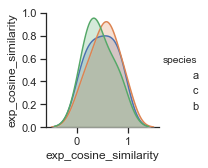

In [1036]:
sns.pairplot(df_tsne_exp_lime_cosine, hue="species")

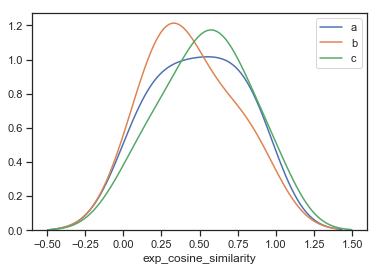

In [1037]:
''' Visualise single component extracted from explanation's cosine similairy matrix variable for each class.
'''
df_hist_plot_a_cosine = df_tsne_exp_lime_cosine[df_tsne_exp_lime_cosine['species'] == 'a']
df_hist_plot_b_cosine = df_tsne_exp_lime_cosine[df_tsne_exp_lime_cosine['species'] == 'b']
df_hist_plot_c_cosine = df_tsne_exp_lime_cosine[df_tsne_exp_lime_cosine['species'] == 'c']

df_hist_plot_a_cosine = df_hist_plot_a_cosine['exp_cosine_similarity']
df_hist_plot_b_cosine = df_hist_plot_b_cosine['exp_cosine_similarity']
df_hist_plot_c_cosine = df_hist_plot_c_cosine['exp_cosine_similarity']

sns.distplot(df_hist_plot_a_cosine, hist=False, label='a')
sns.distplot(df_hist_plot_b_cosine, hist=False, label='b')
sns.distplot(df_hist_plot_c_cosine, hist=False, label='c')

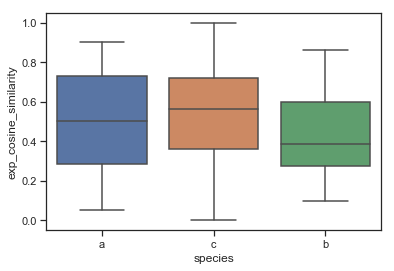

In [1038]:
ax = sns.boxplot(x="species", y="exp_cosine_similarity", data=df_tsne_exp_lime_cosine)

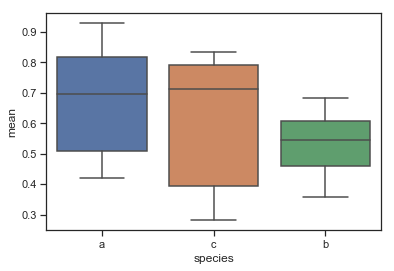

In [980]:
ax = sns.boxplot(x="species", y="mean", data=mean_exp_lime_plot)

In [977]:
df_exp_lime_plot = scaled_exp_lime.copy()
# df_exp_lime_plot = df_exp_lime_plot.astype(int)
# df_exp_lime_plot = df_exp_lime_plot.iloc[:, 0:3]
df_exp_lime_plot['species'] = species_alpha
# df_lime_plot = df_exp_lime_plot.drop(columns=['lime_score'])
df_exp_lime_plot.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,0.867891,1.000000,0.989576,0.864807,a
1,0.782554,0.867763,0.009694,0.022423,a
2,0.919087,0.218552,0.940824,0.969431,c
3,0.675287,0.543560,0.150734,0.218448,c
4,0.764685,0.396880,0.158211,0.248650,c


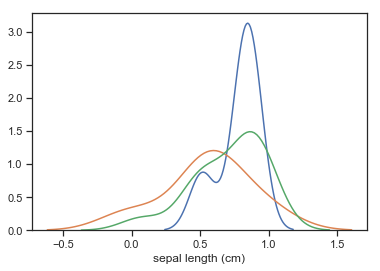

In [978]:
''' Visualise single variable for each class
'''

df_hist_plot_a = df_exp_lime_plot[df_exp_lime_plot['species'] == 'a']
df_hist_plot_b = df_exp_lime_plot[df_exp_lime_plot['species'] == 'b']
df_hist_plot_c = df_exp_lime_plot[df_exp_lime_plot['species'] == 'c']

df_hist_plot_sl_a = df_hist_plot_a['sepal length (cm)']
df_hist_plot_sl_b = df_hist_plot_b['sepal length (cm)']
df_hist_plot_sl_c = df_hist_plot_c['sepal length (cm)']

df_hist_plot_sw_a = df_hist_plot_a['sepal width (cm)']
df_hist_plot_pl_a = df_hist_plot_a['petal length (cm)']
df_hist_plot_pw_a = df_hist_plot_a['petal width (cm)']

sns.distplot(df_hist_plot_sl_a, hist=False)
sns.distplot(df_hist_plot_sl_b, hist=False)
sns.distplot(df_hist_plot_sl_c, hist=False)

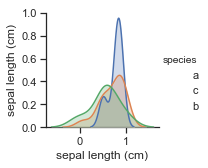

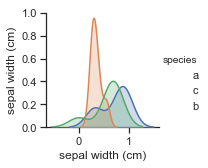

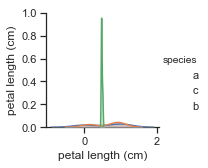

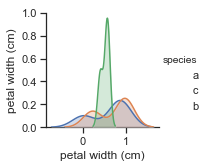

In [852]:
# sns.pairplot(df_exp_lime_plot, hue="species")

sns.pairplot(df_exp_lime_plot.loc[:, ['sepal length (cm)', 'species']], hue="species")
sns.pairplot(df_exp_lime_plot.loc[:, ['sepal width (cm)', 'species']], hue="species")
sns.pairplot(df_exp_lime_plot.loc[:, ['petal length (cm)', 'species']], hue="species")
sns.pairplot(df_exp_lime_plot.loc[:, ['petal width (cm)', 'species']], hue="species")

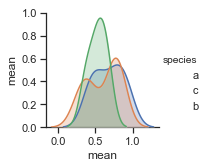

In [818]:
df_exp_lime_plot['mean'] = df_exp_lime_plot.mean(axis=1)
mean_exp_lime_plot = df_exp_lime_plot.loc[:, ['mean', 'species']]
sns.pairplot(mean_exp_lime_plot, hue="species")

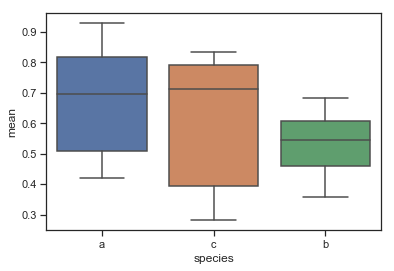

In [819]:
mean_exp_lime_plot.head()
ax = sns.boxplot(x="species", y="mean", data=mean_exp_lime_plot)
# ex_fig.savefig(plots_dir.joinpath('4.2.1/lr_lime_titanic_example.png'))

In [394]:
# df = sns.load_dataset("iris")
# display(df.head())
# display(df_iris_pre.head())

In [411]:
# sns.pairplot(df.sample(frac=1).iloc[0:30].loc[:, ['sepal_length', 'species']], hue="species")
# sns.pairplot(df.sample(frac=1).iloc[0:30].loc[:, ['sepal_width', 'species']], hue="species")
# sns.pairplot(df.sample(frac=1).iloc[0:30].loc[:, ['petal_length', 'species']], hue="species")
# sns.pairplot(df.sample(frac=1).iloc[0:30].loc[:, ['petal_width', 'species']], hue="species")

In [404]:
# sns.pairplot(df.sample(frac=1).iloc[0:30], hue="species")

### 1. Interpreting BB1, SHAP

In [981]:
train_summary = shap.kmeans(train, 50)
bb1_explainer_shap = shap.KernelExplainer(bb1_iris.predict_proba, train_summary)
print(train_summary)

In [1005]:
test_shap_summary = test
exp_shap_values = bb1_explainer_shap.shap_values(test_shap_summary, nsamples='auto')

  0%|          | 0/30 [00:00<?, ?it/s]/Users/adnanbajwa/.local/share/virtualenvs/thesis-project-9ZTRcxDH/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
  3%|▎         | 1/30 [00:00<00:03,  9.18it/s]/Users/adnanbajwa/.local/share/virtualenvs/thesis-project-9ZTRcxDH/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
  7%|▋         | 2/30 [00:00<00:03,  9.31it/s]/Users/adnanbajwa/.local/share/virtualenvs/thesis-project-9ZTRcxDH/lib/python3.6/site-packages/shap/

 67%|██████▋   | 20/30 [00:02<00:01,  9.42it/s]/Users/adnanbajwa/.local/share/virtualenvs/thesis-project-9ZTRcxDH/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 70%|███████   | 21/30 [00:02<00:00,  9.40it/s]/Users/adnanbajwa/.local/share/virtualenvs/thesis-project-9ZTRcxDH/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
 73%|███████▎  | 22/30 [00:02<00:00,  9.21it/s]/Users/adnanbajwa/.local/share/virtualenvs/thesis-project-9ZTRcxDH/lib/python3.6/site-pac

In [539]:
exp_shap_expected_values = bb1_explainer_shap.expected_value
print(exp_shap_expected_values)

[0.33313333 0.36001667 0.30685   ]


#### 1. Interpreting BB1, Preprocessing SHAP values

**_shap_values_** returns 3D array in a form of (num_classes, num_test_instance, num_features) e.g. in our iris dataset it will be (3, 30, 4)

In [1026]:
print(len(np.unique(iris.target)))
print(species_alpha)
print(len(iris.feature_names))
print(len(test_shap_summary))

exp_shap_array = []
for test_index in range(0, len(test_shap_summary)):
    label_pred = bb1_y_pred[test_index]

    exp_shap_array.append(exp_shap_values[label_pred][test_index])

df_exp_shap = pd.DataFrame(exp_shap_array)
df_exp_shap.columns = iris.feature_names
display(df_exp_shap.head())
# exp_shap_values_array = np.array(exp_shap_values)
# print(exp_shap_values_array[0][30])

3
['a', 'a', 'c', 'c', 'c', 'a', 'a', 'c', 'c', 'b', 'c', 'a', 'b', 'c', 'c', 'a', 'c', 'b', 'a', 'c', 'b', 'c', 'b', 'b', 'c', 'a', 'a', 'c', 'a', 'c']
4
30


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,0.036614,0.007319,0.327253,0.295681
1,0.037842,0.005997,0.327253,0.295775
2,0.057897,-0.004189,0.318481,0.316961
3,0.010747,-0.003506,0.134325,0.441583
4,0.022585,0.007399,0.206099,0.413068


In [1027]:
minmax_scaler = MinMaxScaler(feature_range=(0,1))

scaled_exp_shap = minmax_scaler.fit_transform(df_exp_shap.values)
df_scaled_exp_shap = pd.DataFrame(scaled_exp_shap, index=df_exp_shap.index,
                               columns=df_exp_shap.columns)
display(df_scaled_exp_shap.head())

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,0.833185,0.319946,0.996643,0.326185
1,0.842014,0.300338,0.996643,0.326571
2,0.986228,0.149283,0.962441,0.413229
3,0.647185,0.159417,0.244451,0.922972
4,0.732305,0.321120,0.524284,0.806335


#### a. Stability (BB1, SHAP):  Visualise explanation's cosine similairities

Visualise single component extracted from explanation's cosine similairy matrix variable for each class.

In [1128]:
df_scaled_exp_shap_plot = df_scaled_exp_shap.copy()
df_scaled_exp_shap_plot['species'] = species_alpha
# df_scaled_exp_lime_a = df_scaled_exp_lime_a[df_scaled_exp_lime_a['species'] == 'a']


# df_scaled_exp_shap_a = df_scaled_exp_shap_a.head(5)
# display(df_scaled_exp_shap_a)
# df_scaled_exp_shap_a['species'] = species_alpha[:5]
# print(species_alpha[:5])
df_scaled_exp_shap_plot_filtered = df_scaled_exp_shap_plot.iloc[:, :-1]
exp_shap_cosine = cosine_similarity(df_scaled_exp_shap_plot_filtered,
                                    df_scaled_exp_shap_plot_filtered)
df_exp_shap_cosine = pd.DataFrame(exp_shap_cosine)
display(df_exp_shap_cosine.head())

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,1.000000,0.999878,0.985819,0.707788,0.869976,0.999227,0.999985,0.990853,0.990843,0.971279,...,0.998313,0.993661,0.993665,0.995264,0.784188,0.999514,0.995837,0.650725,0.996949,0.988982
1,0.999878,1.000000,0.988051,0.709087,0.869595,0.999718,0.999778,0.991788,0.992167,0.970802,...,0.998282,0.994715,0.993958,0.994843,0.787057,0.999864,0.997088,0.651299,0.998045,0.990817
2,0.985819,0.988051,1.000000,0.759258,0.888821,0.990964,0.984952,0.993216,0.995371,0.942139,...,0.989046,0.995497,0.990373,0.984679,0.836136,0.989648,0.993890,0.702439,0.994534,0.998153
3,0.707788,0.709087,0.759258,1.000000,0.959542,0.710533,0.707194,0.782736,0.769453,0.536148,...,0.738122,0.764609,0.751578,0.750463,0.968527,0.709527,0.707557,0.988417,0.711874,0.762532
4,0.869976,0.869595,0.888821,0.959542,1.000000,0.868469,0.869990,0.913822,0.902479,0.740490,...,0.890231,0.901522,0.896328,0.899793,0.957659,0.868591,0.861206,0.933971,0.865463,0.894313


In [1088]:
model_exp_shap = manifold.TSNE(n_components=2, metric="precomputed")
Y_exp_shap = model_exp_shap.fit_transform(exp_shap_cosine)
Y_exp_shap = minmax_scaler.fit_transform(Y_exp_shap)
df_tsne_exp_shap_cosine = pd.DataFrame(Y_exp_shap).rename(columns={0: 'exp_shap_cs'})
df_tsne_exp_shap_cosine['species'] = species_alpha

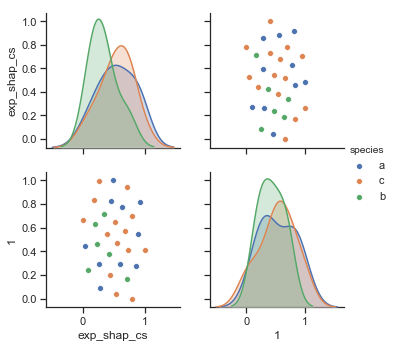

In [1089]:
sns.pairplot(df_tsne_exp_shap_cosine, hue="species")

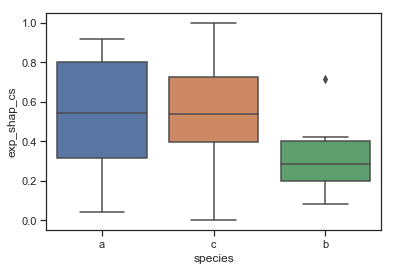

In [1090]:
ax = sns.boxplot(x="species", y="exp_shap_cs", data=df_tsne_exp_shap_cosine)

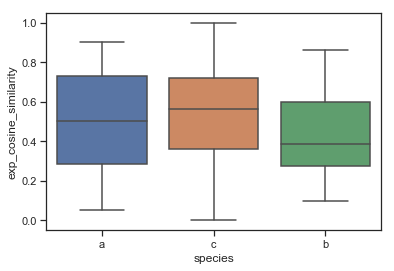

In [1091]:
ax = sns.boxplot(x="species", y="exp_cosine_similarity", data=df_tsne_exp_lime_cosine)

#### b. Stability (BB1, SHAP):  Evaluating explanation's vectors using correlations methologies.

In [1148]:
check = np.corrcoef(df_exp_shap_cosine)
df_scaled_exp_shap_co = pd.DataFrame(check).copy()
df_scaled_exp_shap_co['species'] = species_alpha

df_scaled_exp_shap_co_a = df_scaled_exp_shap_co[df_scaled_exp_shap_co['species'] == 'a'].iloc[:, :-1]
df_scaled_exp_shap_co_b = df_scaled_exp_shap_co[df_scaled_exp_shap_co['species'] == 'b'].iloc[:, :-1]
df_scaled_exp_shap_co_c = df_scaled_exp_shap_co[df_scaled_exp_shap_co['species'] == 'c'].iloc[:, :-1]

take_five = df_scaled_exp_shap_co.head(5)

In [1149]:
take_five.head()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,species
0,1.000000,0.999847,0.965081,-0.467538,0.011560,0.999056,0.999979,0.974449,0.976752,0.975743,...,0.983170,0.982006,0.990800,-0.095420,0.999460,0.996041,-0.577310,0.996389,0.973729,a
1,0.999847,1.000000,0.969353,-0.455102,0.024496,0.999663,0.999714,0.977632,0.979910,0.972997,...,0.985895,0.983980,0.991728,-0.081243,0.999856,0.997358,-0.566169,0.997721,0.977351,a
2,0.965081,0.969353,1.000000,-0.241753,0.237154,0.975132,0.963396,0.991667,0.992109,0.900714,...,0.992689,0.986770,0.979264,0.132959,0.972101,0.981128,-0.363429,0.983050,0.996307,c
3,-0.467538,-0.455102,-0.241753,1.000000,0.874578,-0.436488,-0.472138,-0.269415,-0.284234,-0.627099,...,-0.307923,-0.341236,-0.385881,0.891453,-0.445474,-0.409281,0.981034,-0.406181,-0.270354,c
4,0.011560,0.024496,0.237154,0.874578,1.000000,0.043550,0.006722,0.217385,0.200203,-0.182032,...,0.177946,0.141935,0.099980,0.945425,0.034274,0.069825,0.796108,0.073866,0.211848,c


In [1138]:
cov_matrix_a = np.corrcoef(df_scaled_exp_shap_co_a)
cov_matrix_b = np.corrcoef(df_scaled_exp_shap_co_b)
cov_matrix_c = np.corrcoef(df_scaled_exp_shap_co_c)
# print(cov_matrix_a)
# print(cov_matrix_b)
# print(cov_matrix_c)

In [1150]:
centroid_a = np.mean(df_scaled_exp_shap_co_a)
centroid_b = np.mean(df_scaled_exp_shap_co_b)
centroid_c = np.mean(df_scaled_exp_shap_co_c)

centroid_a = pd.DataFrame(centroid_a, columns=['centroid'])
centroid_a['species'] = 'a'
centroid_b = pd.DataFrame(centroid_b, columns=['centroid'])
centroid_b['species'] = 'b'
centroid_c = pd.DataFrame(centroid_c, columns=['centroid'])
centroid_c['species'] = 'c'

result = centroid_a.append(centroid_b)
result = result.append(centroid_c)
display(result)

,centroid,species
0,0.971078,a
1,0.970042,a
2,0.922820,a
3,-0.493323,a
4,-0.030692,a
5,0.967964,a
6,0.971412,a
7,0.938107,a
8,0.940598,a
9,0.952684,a


### SHAP, LIME comparison Plots

#### SHAP correlations vectors based centroid

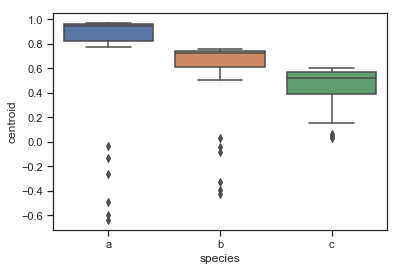

In [1151]:
ax = sns.boxplot(x="species", y="centroid", data=result)

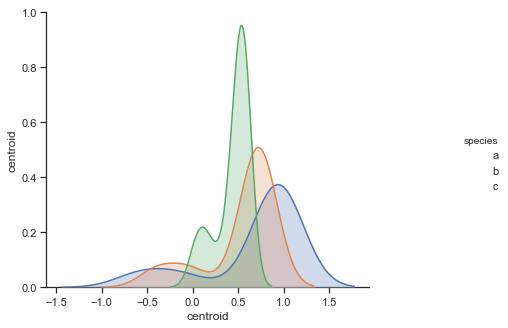

In [1163]:
ax = sns.pairplot(result, hue="species")
ax.fig.set_size_inches(9,6)

#### LIME correlations vectors based centroid

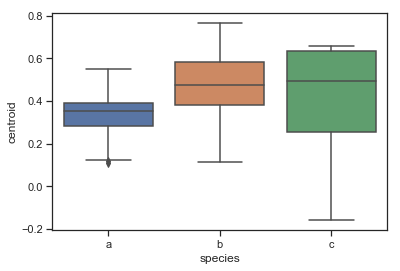

In [1146]:
ax = sns.boxplot(x="species", y="centroid", data=result)

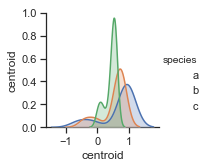

In [1164]:
sns.pairplot(result, hue="species")

#### SHAP distance based centroid

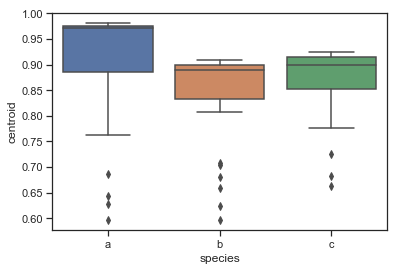

In [1133]:
ax = sns.boxplot(x="species", y="centroid", data=result)

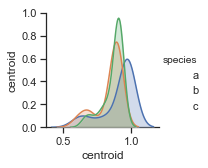

In [1134]:
sns.pairplot(result, hue="species")

#### LIME distance based centroid

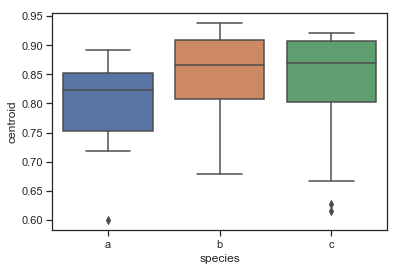

In [1140]:
ax = sns.boxplot(x="species", y="centroid", data=result)

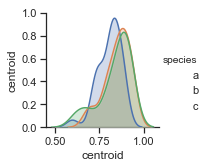

In [1141]:
sns.pairplot(result, hue="species")

#### SHAP expplanations vectors based centroid

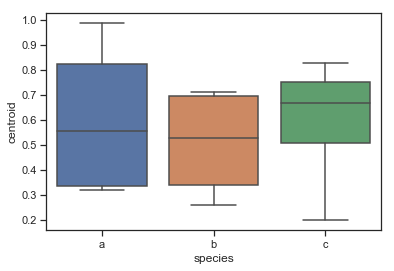

In [1120]:
ax = sns.boxplot(x="species", y="centroid", data=result)

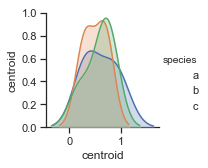

In [1121]:
sns.pairplot(result, hue="species")

#### LIME expplanations vectors based centroid

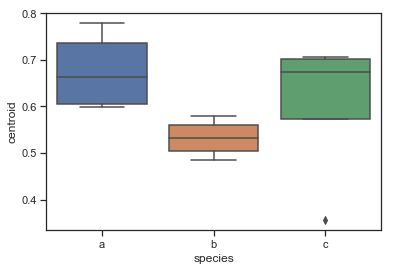

In [1126]:
ax = sns.boxplot(x="species", y="centroid", data=result)

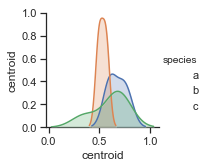

In [1127]:
sns.pairplot(result, hue="species")

#### SHAP practice

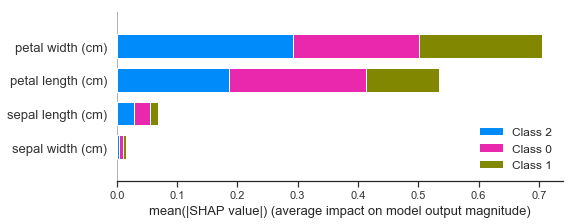

In [544]:
shap.summary_plot(exp_shap_values, features=test_shap_summary ,feature_names=iris.feature_names, plot_type='violin')

In [499]:
# i = np.random.randint(0, test.shape[0])
# exp_shap = bb1_explainer_shap.shap_values(test[i])
# shap.force_plot(bb1_explainer_shap.expected_value[0], exp_shap[0], test[i], feature_names=iris.feature_names)

In [500]:
# shap.force_plot(bb1_explainer_shap.expected_value[0], shap_values[0], test[i])

In [501]:
# exp_shap_array = np.array(exp_shap)
# print(len(exp_shap))

In [502]:
# shap_expected_values = bb1_explainer_shap.expected_value
# print(shap_expected_values)
# shap_values = bb1_explainer_shap.shap_values(test[i])
# print(shap_values)

In [503]:
# shap_expected_values = bb1_explainer_shap.expected_value

# shap_values = bb1_explainer_shap.shap_values(test)

In [504]:
# print(shap_expected_values)
# print(shap_values[0])

## Comparisons of Explanations

## Conclusions